# Testing Hough transform for imaging fluid flow with streaks analysis

## Prepatory steps

Get some includes first and define convenience routines

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py
import time
import math
from numpy import random

from skimage.transform import probabilistic_hough_line
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from matplotlib import cm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Here, we will be using progressive probabilistic line Hough transform implementation from skimage. 

The method is described in

C. Galamhos, J. Matas and J. Kittler, “Progressive probabilistic Hough transform for line detection”, in IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 1999

In [ ]:
def probHoughTransform(image, threshold=15, line_length=4, line_gap=5):
    
    edges = canny(image, 1, 5, 25)
    lines = probabilistic_hough_line(edges, threshold=15, line_length=4,
                                     line_gap=5)
    Dx=[]
    Dy=[]
    for line in lines:
        p0, p1 = line
        dx=p1[0]-p0[0]
        dy=p1[1]-p0[1]
        Dx.append(dx)
        Dy.append(dy)

            
    Dx=np.array(Dx)
    Dy=np.array(Dy)
    displacement=np.sqrt(Dx**2+Dy**2)
    angle=np.rad2deg(np.arctan(Dy/Dx))
    predictionDelta= displacement.mean()
    predictionAngle=angle.mean()
    rmsDelta=displacement.std()
    rmsAngle=angle.std()

    return lines,displacement,angle,predictionDelta,predictionAngle,rmsDelta,rmsAngle

Load validation set

In [2]:
file_net = 'network_grayscale_gradient_uniformDisp_n=1M'

h5f = h5py.File(('networks/%s_data.h5' % file_net), 'r')

testImages = h5f['validationImages'][()]
testData = h5f['validationData'][()]
scale = h5f['scale'][()]
mean = h5f['mean'][()]
windowSize = h5f['windowSize'][()]
n_ensemble_members = h5f['n_ensemble_members'][()]
filter_size = h5f['filter_size'][()]
padding = h5f['padding'][()]
h5f.close()

## Apply Hough Transform to the validation set

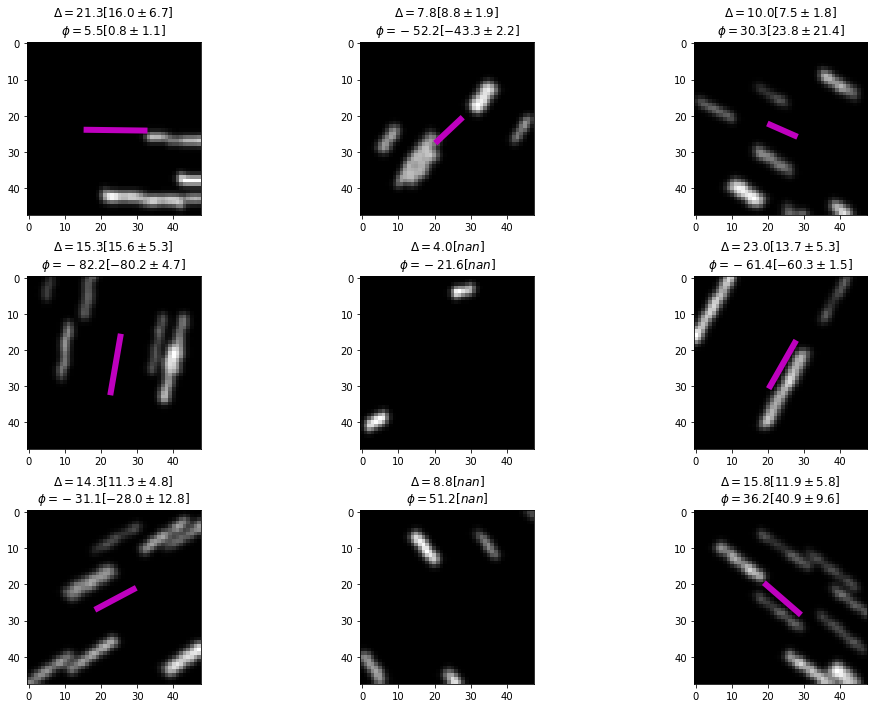

Testing finished, took 2.5060s.


In [3]:
Nimages=9
indices = random.randint(0, len(testImages), Nimages)

fig = plt.figure()
numberEmptyLines=0

start_time = time.time()
for i in range(indices.size):
    ax = fig.add_subplot(3, 3, i + 1)
    plt.gray()
    plt.imshow(testImages[indices[i],0,:,:])

    lines,displacement,angle,predictionDelta,predictionAngle,rmsDelta,rmsAngle\
    =probHoughTransform(testImages[indices[i],0,:,:],\
     threshold=15, line_length=4,line_gap=2)
    
    if len(lines)==0:
        numberEmptyLines+=1
        ax.set_title("$\Delta = %.1f [nan]$\n$\phi = %.1f [nan]$" \
                 % (testData[indices[i],0],\
                    testData[indices[i],1]))
    if len(lines)!=0:
        xc = windowSize / 2
        yc = windowSize / 2

        x0 = xc - math.cos(predictionAngle * math.pi / 180) * predictionDelta / 2.
        x1 = xc + math.cos(predictionAngle * math.pi / 180) * predictionDelta / 2.

        y0 = yc - math.sin(predictionAngle * math.pi / 180) * predictionDelta / 2.
        y1 = yc + math.sin(predictionAngle * math.pi / 180) * predictionDelta / 2. 
        plt.plot((x0, x1), (y0, y1),linewidth=6,color = 'm')
        ax.set_title("$\Delta = %.1f [%.1f \pm %.1f]$\n$\phi = %.1f [%.1f \pm %.1f]$" \
                 % (testData[indices[i],0], predictionDelta, rmsDelta,\
                    testData[indices[i],1], predictionAngle,rmsAngle))
    
    plt.title
    plt.tight_layout()
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
fig.subplots_adjust(hspace=0.35, wspace = 0.01)
plt.show()

elapsed_time = time.time() - start_time
print("Testing finished, took {:.4f}s.".format(elapsed_time))

Apply to all images and calculate accuracy in the same way we do for CNNs

Testing finished, took 2.3821s for 1000 images.
number of images with undetected lines= 342


Text(0.5, 0, 'Residuals of $\\phi$ (degrees)')

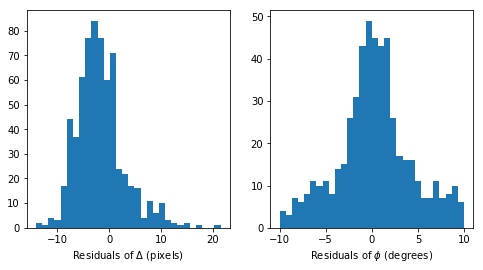

In [5]:
Nimages=1000
indices = random.randint(0, len(testImages), Nimages)
Delta_residuals=[]
Angle_residuals=[]
predictionDelta=[]
predictionAngle=[]
rmsDelta=[]
rmsAngle=[]

numberEmptyLines=0

start_time = time.time()
for i in range(indices.size):
    lines,displacements,angles,Delta,Angle,rmsD,rmsA\
    =probHoughTransform(testImages[indices[i],0,:,:],\
     threshold=15, line_length=4,line_gap=5)
    
    if len(lines)==0:
        numberEmptyLines+=1
        predictionDelta.append(np.nan)
        predictionAngle.append(np.nan)
        rmsDelta.append(np.nan)
        rmsAngle.append(np.nan)
        Delta_residuals.append(np.nan)
        Angle_residuals.append(np.nan)
    else:    
        predictionDelta.append(Delta)
        predictionAngle.append(Angle)
        rmsDelta.append(rmsD)
        rmsAngle.append(rmsA)
        Delta_residuals.append(Delta-testData[indices[i],0])
        Angle_residuals.append(Angle-testData[indices[i],1])
    
predictionDelta=np.array(predictionDelta)
predictionDelta= predictionDelta[~np.isnan(predictionDelta)]

predictionAngle=np.array(predictionAngle)
predictionAngle= predictionAngle[~np.isnan(predictionAngle)]

rmsDelta=np.array(rmsDelta)
rmsDelta= rmsDelta[~np.isnan(rmsDelta)]

rmsAngle=np.array(rmsAngle)
rmsAngle= rmsAngle[~np.isnan(rmsAngle)]

Delta_residuals=np.array(Delta_residuals)
Delta_residuals= Delta_residuals[~np.isnan(Delta_residuals)]

Angle_residuals=np.array(Angle_residuals)
Angle_residuals= Angle_residuals[~np.isnan(Angle_residuals)]



elapsed_time = time.time() - start_time
print("Testing finished, took {:.4f}s for {:.0f} images.".format(elapsed_time,Nimages))
print('number of images with undetected lines= {:.0f}'.format(numberEmptyLines))

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,2,1)
#plt.hist(yresiduals[:,0], 30, (-8, 8));
plt.hist(Delta_residuals,30)
plt.xlabel('Residuals of $\Delta$ (pixels)')
ax = fig.add_subplot(1,2,2)
#plt.hist(yresiduals[:,1], 30, (-10, 10));
plt.hist(Angle_residuals,30, (-10,10))
plt.xlabel('Residuals of $\phi$ (degrees)')